# Copyright Netherlands eScience Center <br>
**Function     : Paper Fig - comparison between forecasts with one-time-sampling and rapid sampling** <br>
**Author       : Yang Liu** <br>
**First Built  : 2020.07.08** <br>
**Last Update  : 2020.07.08** <br>
**Library      : Pytorth, Numpy, NetCDF4, os, iris, cartopy, dlacs, matplotlib**<br>
Description     : This notebook serves to make figures for the paper. <br>

The Lorens-84 model is described by Edward Lorens in his 1984 paper:<br>
Lorenz, E. N. (1984). Irregularity: A fundamental property of the atmosphere. Tellus A, 36(2), 98-110.<br>

Return Values   : Time series and figures <br>

In [1]:
%matplotlib inline

import sys
import warnings
import numbers

# for data loading
import os
from netCDF4 import Dataset
# for pre-processing and machine learning
import numpy as np
import csv
#import sklearn
#import scipy
import torch
import torch.nn.functional

#sys.path.append(os.path.join('C:','Users','nosta','ML4Climate','Scripts','DLACs'))
sys.path.append("C:\\Users\\nosta\\ML4Climate\\Scripts\\DLACs")
#sys.path.append("../")
import dlacs
import dlacs.BayesConvLSTM
import dlacs.preprocess
import dlacs.function
import dlacs.saveNetCDF
import dlacs.metric

# for visualization
import dlacs.visual
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from mpl_toolkits.mplot3d import Axes3D
import iris # also helps with regriding
import cartopy
import cartopy.crs as ccrs

# ignore all the DeprecationWarnings by pytorch
if not sys.warnoptions:
    warnings.simplefilter("ignore")
###############################################################################79

The testing device is Dell Inspirion 5680 with Intel Core i7-8700 x64 CPU and Nvidia GTX 1060 6GB GPU.<br>
Here is a benchmark about cpu v.s. gtx 1060 <br>
https://www.analyticsindiamag.com/deep-learning-tensorflow-benchmark-intel-i5-4210u-vs-geforce-nvidia-1060-6gb/

In [2]:
# constants
constant = {'g' : 9.80616,      # gravititional acceleration [m/s2]
            'R' : 6371009,      # radius of the earth [m]
            'cp': 1004.64,      # heat capacity of air [J/(Kg*K)]
            'Lv': 2500000,      # Latent heat of vaporization [J/Kg]
            'R_dry' : 286.9,    # gas constant of dry air [J/(kg*K)]
            'R_vap' : 461.5,    # gas constant for water vapour [J/(kg*K)]
            'rho' : 1026,       # sea water density [kg/m3]
            }

In [3]:
################################################################################# 
#########                           datapath                             ########
#################################################################################
ಠ_ಠ = "I'm a valid variable name!"
print(ಠ_ಠ)
# datapath for output
output_path = 'C:\\Users\\nosta\\ML4Climate\\PredictArctic\\BayesMaps\\Lorenz84\\bayes\\fullseries_ex\\paperFig'
# datapath of forecast
pred_rapid_path = 'C:\\Users\\nosta\\ML4Climate\\PredictArctic\\BayesMaps\\Lorenz84\\bayes\\fullseries_ex\\penalty100\\longLeadTime'
pred_onetime_path = 'C:\\Users\\nosta\\ML4Climate\\PredictArctic\\BayesMaps\\Lorenz84\\bayes\\fullseries_ex\\penalty100\\FixedSample'

I'm a valid variable name!


In [4]:
if __name__=="__main__":
    #################################################################################
    ###########                configure Lorenz 84 model                  ###########
    #################################################################################
    # Lorenz paramters and initial conditions
    x_init = 1.0 # strength of the symmetric globally encircling westerly current
    y_init = 1.0 # strength of the cosine phases of a chain of superposedwaves (large scale eddies)
    z_init = 1.0 # strength of the sine phases of a chain of superposedwaves (large scale eddies)
    F = 8.0 # temperature difference between pole and equator
    G = 1.0 # thermal forcing term
    epsilon = 0.4 # intensity of periodic forcing
    a = 0.25 # mechanical damping factor for westerly wind x
    b = 4.0 # advection strength of the waves by the westerly current
    
    # assuming the damping time for the waves is 5 days (Lorens 1984)
    dt = 0.0333 # 1/30 unit of time unit (5 days)
    num_steps = 1500
    # cut-off point of initialization period
    cut_off = 0
    # target testing period
    test_len = 200

#### Ensemble<br>
##### Testing benchmark <br>
- Lorenz 84 model initial set-up <br>
**x=1.0, y=1.0, z=1.0, a=0.25, b=4.0, F=8.0, G=1.0, epsilon=0.4** <br>

In [5]:
    #################################################################################
    ###########            Lorens 84 model + periodic forcing             ###########
    #################################################################################
    def lorenz84_ex(x, y, z, t, a = 0.25, b = 4.0, F = 8.0, G = 1.0, epsilon = 1.0):
        """
        Solver of Lorens-84 model with periodic external forcing.
        
        param x, y, z: location in a 3D space
        param a, b, F, G: constants and forcing
        
        The model is designed with a reference to the paper:
        Broer, H., Simó, C., & Vitolo, R. (2002). Bifurcations and strange
        attractors in the Lorenz-84 climate model with seasonal forcing. Nonlinearity, 15(4), 1205.
        
        Song, Y., Yu, Y., & Wang, H. (2011, October). The stability and chaos analysis of the
        Lorenz-84 atmosphere model with seasonal forcing. In 2011 Fourth International Workshop
        on Chaos-Fractals Theories and Applications (pp. 37-41). IEEE.
        """
        # each time step is ~ 5days, therefore the returning period are 365 / 5 = 73 times in a year
        T = 73
        omega = 2 * np.pi / T
        dx = - y**2 - z**2 - a * x + a * F * (1 + epsilon * np.cos(omega * t))
        dy = x * y - b * x * z - y + G * (1 + epsilon * np.sin(omega * t))
        dz = b * x * y + x * z - z
        
        return dx, dy, dz

In [6]:
    #################################################################################
    ###########        Launch Lorenz 84 model with periodic forcing       ###########
    #################################################################################   
    # Need one more for the initial values
    x = np.empty(num_steps)
    y = np.empty(num_steps)
    z = np.empty(num_steps)
    t = 0.0
    
    # save initial values
    x[0] = x_init
    y[0] = y_init
    z[0] = z_init
    
    # Step through "time", calculating the partial derivatives at the current point
    # and using them to estimate the next point
    for i in range(num_steps-1):
        dx, dy, dz = lorenz84_ex(x[i], y[i], z[i], t, a, b ,F, G, epsilon)
        x[i + 1] = x[i] + (dx * dt)
        y[i + 1] = y[i] + (dy * dt)
        z[i + 1] = z[i] + (dz * dt)
        t += dt

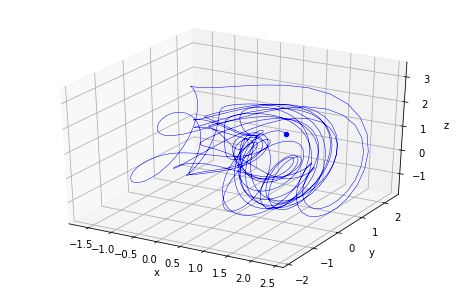

<Figure size 432x288 with 0 Axes>

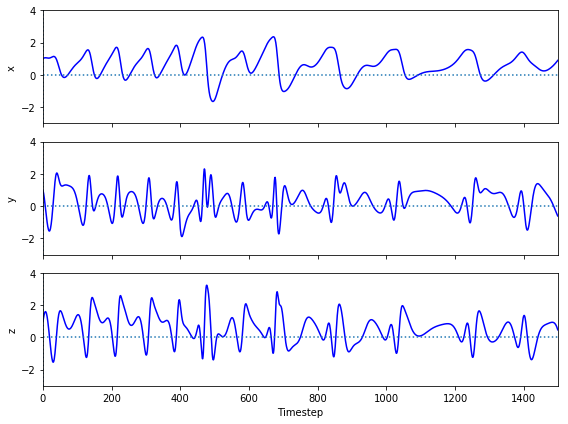

In [7]:
    #################################################################################
    ###########                 Visualize Lorens 84 model                    ###########
    #################################################################################   
    # save Lorens model output
    index = np.arange(num_steps)
    # Plot
    fig00 = plt.figure(figsize=(6.5,4.2))
    ax = fig00.gca(projection='3d')
    ax.plot(x, y, z, 'b', lw=0.5)
    ax.scatter3D(x[0], y[0], z[0], color = 'b')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    #ax.set_title("Lorenz-84 model")
    plt.tight_layout()
    plt.show()
    fig00.savefig(os.path.join(output_path, 'lorenz84_trajectory'),dpi=150) 
        
    fig01 = plt.figure()
    fig01, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig01.set_size_inches(8, 6, forward=True)
    ax1.plot(index, x, 'b', label='x')
    ax2.plot(index, y, 'b', label='y')
    ax3.plot(index, z, 'b', label='z')
    
    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')
    
    ax1.axvline(x=cut_off, ls = ':')
    ax2.axvline(x=cut_off, ls = ':')
    ax3.axvline(x=cut_off, ls = ':')
    
    ax1.set_xlim(0, num_steps)
    ax2.set_xlim(0, num_steps)
    ax3.set_xlim(0, num_steps)
    
    ax1.set_ylim(-3, 4)
    ax2.set_ylim(-3, 4)
    ax3.set_ylim(-3, 4)
    
    ax1.set_ylabel("x")
    ax2.set_ylabel("y")
    ax3.set_ylabel("z")
    
    plt.xlabel("Timestep")
    
    #ax1.legend()
    #ax2.legend()
    #ax3.legend()
    
    plt.tight_layout()
    plt.show()
    fig01.savefig(os.path.join(output_path, 'lorenz84_series'),dpi=150) 

In [8]:
    print ('*******************  pre-processing  *********************')
    # time series cut-off
    if cut_off:
        x = x[cut_off:]
        y = y[cut_off:]
        z = z[cut_off:]
    print ('===================  normalize data  =====================')
    x_norm = dlacs.preprocess.operator.normalize(x)
    y_norm = dlacs.preprocess.operator.normalize(y)
    z_norm = dlacs.preprocess.operator.normalize(z)
    print('================  save the normalizing factor  =================')
    # maximum and minimum
    x_max = np.amax(x)
    x_min = np.amin(x)
    y_max = np.amax(y)
    y_min = np.amin(y)
    z_max = np.amax(z)
    z_min = np.amin(z)
    # std
    x_std = np.std(x)
    y_std = np.std(y)
    z_std = np.std(z)

*******************  pre-processing  *********************
===================  normalize data  =====================
================  save the normalizing factor  =================


In [9]:
    #######################################################################
    #######    Load forecast of Lorenz 84 model by BayesConvLSTM    #######
    #######################################################################
    print ('*******************  load ensemble data  *********************')
    # predict x steps ahead
    step_lead = 730 # unit time step
    # number of ensembles
    ens = 20
    predictand_rapid = np.zeros((ens, 3, test_len, step_lead), dtype=float)
    predictand_onetime = np.zeros((ens, 3, test_len, step_lead), dtype=float)
    for i in range(ens):
        dataset_pred_rapid = Dataset(os.path.join(pred_rapid_path, 'pred_lorenz84_ens_{}.nc'.format(i)))
        predictand_rapid[i,:,:,:] = dataset_pred_rapid.variables['series'][:]
        dataset_pred_onetime = Dataset(os.path.join(pred_onetime_path, 'pred_lorenz84_sample_{}.nc'.format(i)))
        predictand_onetime[i,:,:,:] = dataset_pred_onetime.variables['series'][:]        
    print(predictand_rapid.shape)
    predictand_rapid_median = np.median(predictand_rapid, 0)
    predictand_onetime_median = np.median(predictand_onetime, 0)

*******************  load ensemble data  *********************
(20, 3, 200, 730)


<Figure size 432x288 with 0 Axes>

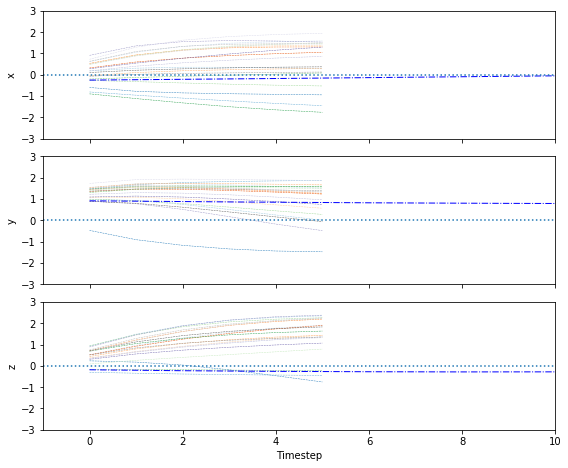

In [10]:
    # just for check of initial startings
    colormap=cm.tab20c(range(ens))
    step_lead_display = 6
    index = np.arange(test_len)
    index_lead = np.arange(test_len + step_lead_display)
    fig033 = plt.figure()
    fig033, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig033.set_size_inches(8.0, 6.6, forward=True)
    for i in range(ens):
        ax1.plot(index_lead[:step_lead_display], predictand_onetime[i, 0, 0, :step_lead_display] * (x_max - x_min) + x_min,
                 color=colormap[i], linestyle='dashed', linewidth = 0.5)
        ax2.plot(index_lead[:step_lead_display], predictand_onetime[i, 1, 0, :step_lead_display] * (y_max - y_min) + y_min,
                 color=colormap[i], linestyle='dashed', linewidth = 0.5)
        ax3.plot(index_lead[:step_lead_display], predictand_onetime[i, 2, 0, :step_lead_display] * (z_max - z_min) + z_min,
                 color=colormap[i], linestyle='dashed', linewidth = 0.5)
        
    # obs
    ax1.plot(index, x[-test_len:], color='blue', linestyle='dashdot', linewidth = 1.0, label='model output')
    ax2.plot(index, y[-test_len:], color='blue', linestyle='dashdot', linewidth = 1.0, label='model output')
    ax3.plot(index, z[-test_len:], color='blue', linestyle='dashdot', linewidth = 1.0, label='model output')
        
    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')    
    
    ax1.set_ylim(-3, 3)
    ax2.set_ylim(-3, 3)
    ax3.set_ylim(-3, 3)

    ax1.set_xlim(-1, 10)
    ax2.set_xlim(-1, 10)
    ax3.set_xlim(-1, 10)
    
    #ax1.legend(frameon=True, loc=3, prop={'size': 7.5}, ncol=7)
    #ax2.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0, prop={'size': 9.0}, ncol=2)
    #ax3.legend(frameon=True, loc=3, prop={'size': 7.5}, ncol=7)

    ax1.set_ylabel("x")
    ax2.set_ylabel("y")
    ax3.set_ylabel("z")
    
    plt.xlabel("Timestep")
    
    plt.tight_layout()
    plt.show()

<Figure size 432x288 with 0 Axes>

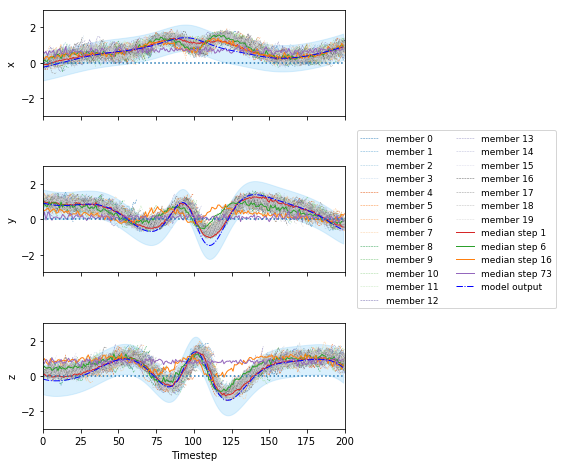

<Figure size 432x288 with 0 Axes>

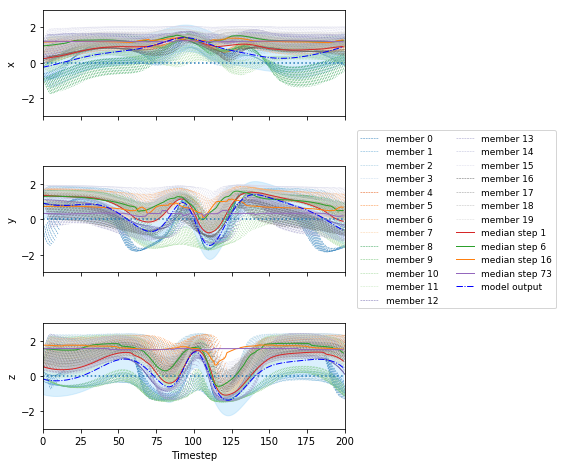

In [12]:
    ##################################################################################################
    ########    visualization of lead time dependent prediction - timeseries with lead time   ########
    ##################################################################################################
    #colormap=cm.Accent(range(ens))
    #colormap=cm.Set1(range(ens))
    #colormap=cm.tab10(range(ens))
    colormap=cm.tab20c(range(ens))
    #colormap=cm.jet(range(ens))
    
    # Get colors from colormap
    #colormap = plt.get_cmap('coolwarm', step_lead)
    #colormap = plt.get_cmap('jet', 51)
    
    step_lead_display = 6
    
    index = np.arange(test_len)
    index_lead = np.arange(test_len + step_lead_display)
    
    # rapid forecast
    
    fig02 = plt.figure()
    fig02, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig02.set_size_inches(8.0, 6.6, forward=True)
    
    # each member
    for i in range(ens):
        for j in range(test_len):
            if j == 0:
                # only for legend
                ax1.plot(index_lead[j:j+step_lead_display], predictand_rapid[i, 0, j, :step_lead_display] * (x_max - x_min) + x_min,
                         color=colormap[i], linestyle='dashed', linewidth = 0.5, label='member {}'.format(i))
                ax2.plot(index_lead[j:j+step_lead_display], predictand_rapid[i, 1, j, :step_lead_display] * (y_max - y_min) + y_min,
                         color=colormap[i], linestyle='dashed', linewidth = 0.5, label='member {}'.format(i))
                ax3.plot(index_lead[j:j+step_lead_display], predictand_rapid[i, 2, j, :step_lead_display] * (z_max - z_min) + z_min,
                         color=colormap[i], linestyle='dashed', linewidth = 0.5, label='member {}'.format(i))
            else:
                ax1.plot(index_lead[j:j+step_lead_display], predictand_rapid[i, 0, j, :step_lead_display] * (x_max - x_min) + x_min,
                         color=colormap[i], linestyle='dashed', linewidth = 0.5)
                ax2.plot(index_lead[j:j+step_lead_display], predictand_rapid[i, 1, j, :step_lead_display] * (y_max - y_min) + y_min,
                         color=colormap[i], linestyle='dashed', linewidth = 0.5)
                ax3.plot(index_lead[j:j+step_lead_display], predictand_rapid[i, 2, j, :step_lead_display] * (z_max - z_min) + z_min,
                         color=colormap[i], linestyle='dashed', linewidth = 0.5)                
            
    # median
    # step 1
    ax1.plot(index, predictand_rapid_median[0, :, 0] * (x_max - x_min) + x_min,
             color='tab:red', linestyle='solid', label='median step 1', linewidth = 1.0)
    ax2.plot(index, predictand_rapid_median[1, :, 0] * (y_max - y_min) + y_min,
             color='tab:red', linestyle='solid', label='median step 1', linewidth = 1.0)
    ax3.plot(index, predictand_rapid_median[2, :, 0] * (z_max - z_min) + z_min,
             color='tab:red', linestyle='solid', label='median step 1', linewidth = 1.0)
    
    # step 6
    ax1.plot(index, predictand_rapid_median[0, :, 5] * (x_max - x_min) + x_min,
             color='tab:green', linestyle='solid', label='median step 6', linewidth = 1.0)
    ax2.plot(index, predictand_rapid_median[1, :, 5] * (y_max - y_min) + y_min,
             color='tab:green', linestyle='solid', label='median step 6', linewidth = 1.0)
    ax3.plot(index, predictand_rapid_median[2, :, 5] * (z_max - z_min) + z_min,
             color='tab:green', linestyle='solid', label='median step 6', linewidth = 1.0)
    
    # step 16
    ax1.plot(index, predictand_rapid_median[0, :, 15] * (x_max - x_min) + x_min,
             color='tab:orange', linestyle='solid', label='median step 16', linewidth = 1.0)
    ax2.plot(index, predictand_rapid_median[1, :, 15] * (y_max - y_min) + y_min,
             color='tab:orange', linestyle='solid', label='median step 16', linewidth = 1.0)
    ax3.plot(index, predictand_rapid_median[2, :, 15] * (z_max - z_min) + z_min,
             color='tab:orange', linestyle='solid', label='median step 16', linewidth = 1.0)
    
    # step 73
    ax1.plot(index, predictand_rapid_median[0, :, 72] * (x_max - x_min) + x_min,
             color='tab:purple', linestyle='solid', label='median step 73', linewidth = 1.0)
    ax2.plot(index, predictand_rapid_median[1, :, 72] * (y_max - y_min) + y_min,
             color='tab:purple', linestyle='solid', label='median step 73', linewidth = 1.0)
    ax3.plot(index, predictand_rapid_median[2, :, 72] * (z_max - z_min) + z_min,
             color='tab:purple', linestyle='solid', label='median step 73', linewidth = 1.0)

    # obs
    ax1.plot(index, x[-test_len:], color='blue', linestyle='dashdot', linewidth = 1.0, label='model output')
    ax2.plot(index, y[-test_len:], color='blue', linestyle='dashdot', linewidth = 1.0, label='model output')
    ax3.plot(index, z[-test_len:], color='blue', linestyle='dashdot', linewidth = 1.0, label='model output')
    # obs std band
    ax1.fill_between(index, x[-test_len:] + x_std, x[-test_len:] - x_std,
                     alpha=0.3,edgecolor='lightskyblue', facecolor='lightskyblue')
    ax2.fill_between(index, y[-test_len:] + y_std, y[-test_len:] - y_std,
                     alpha=0.3,edgecolor='lightskyblue', facecolor='lightskyblue')
    ax3.fill_between(index, z[-test_len:] + z_std, z[-test_len:] - z_std,
                     alpha=0.3,edgecolor='lightskyblue', facecolor='lightskyblue')    
    
    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')    
    
    ax1.set_ylim(-3, 3)
    ax2.set_ylim(-3, 3)
    ax3.set_ylim(-3, 3)

    ax1.set_xlim(0, test_len)
    ax2.set_xlim(0, test_len)
    ax3.set_xlim(0, test_len)
    
    #ax1.legend(frameon=True, loc=3, prop={'size': 7.5}, ncol=7)
    ax2.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0, prop={'size': 9.0}, ncol=2)
    #ax3.legend(frameon=True, loc=3, prop={'size': 7.5}, ncol=7)

    ax1.set_ylabel("x")
    ax2.set_ylabel("y")
    ax3.set_ylabel("z")
    
    plt.xlabel("Timestep")
    
    plt.tight_layout()

    plt.show()
    fig02.savefig(os.path.join(output_path,'forecast_rapid_series.png'),dpi=150)
    
    # one-time forecast
    
    fig03 = plt.figure()
    fig03, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig03.set_size_inches(8.0, 6.6, forward=True)
    
    # each member
    for i in range(ens):
        for j in range(test_len):
            if j == 0:
                # only for legend
                ax1.plot(index_lead[j:j+step_lead_display], predictand_onetime[i, 0, j, :step_lead_display] * (x_max - x_min) + x_min,
                         color=colormap[i], linestyle='dashed', linewidth = 0.5, label='member {}'.format(i))
                ax2.plot(index_lead[j:j+step_lead_display], predictand_onetime[i, 1, j, :step_lead_display] * (y_max - y_min) + y_min,
                         color=colormap[i], linestyle='dashed', linewidth = 0.5, label='member {}'.format(i))
                ax3.plot(index_lead[j:j+step_lead_display], predictand_onetime[i, 2, j, :step_lead_display] * (z_max - z_min) + z_min,
                         color=colormap[i], linestyle='dashed', linewidth = 0.5, label='member {}'.format(i))
            else:
                ax1.plot(index_lead[j:j+step_lead_display], predictand_onetime[i, 0, j, :step_lead_display] * (x_max - x_min) + x_min,
                         color=colormap[i], linestyle='dashed', linewidth = 0.5)
                ax2.plot(index_lead[j:j+step_lead_display], predictand_onetime[i, 1, j, :step_lead_display] * (y_max - y_min) + y_min,
                         color=colormap[i], linestyle='dashed', linewidth = 0.5)
                ax3.plot(index_lead[j:j+step_lead_display], predictand_onetime[i, 2, j, :step_lead_display] * (z_max - z_min) + z_min,
                         color=colormap[i], linestyle='dashed', linewidth = 0.5)                
            
    # median
    # step 1
    ax1.plot(index, predictand_onetime_median[0, :, 0] * (x_max - x_min) + x_min,
             color='tab:red', linestyle='solid', label='median step 1', linewidth = 1.0)
    ax2.plot(index, predictand_onetime_median[1, :, 0] * (y_max - y_min) + y_min,
             color='tab:red', linestyle='solid', label='median step 1', linewidth = 1.0)
    ax3.plot(index, predictand_onetime_median[2, :, 0] * (z_max - z_min) + z_min,
             color='tab:red', linestyle='solid', label='median step 1', linewidth = 1.0)
    
    # step 6
    ax1.plot(index, predictand_onetime_median[0, :, 5] * (x_max - x_min) + x_min,
             color='tab:green', linestyle='solid', label='median step 6', linewidth = 1.0)
    ax2.plot(index, predictand_onetime_median[1, :, 5] * (y_max - y_min) + y_min,
             color='tab:green', linestyle='solid', label='median step 6', linewidth = 1.0)
    ax3.plot(index, predictand_onetime_median[2, :, 5] * (z_max - z_min) + z_min,
             color='tab:green', linestyle='solid', label='median step 6', linewidth = 1.0)
    
    # step 16
    ax1.plot(index, predictand_onetime_median[0, :, 15] * (x_max - x_min) + x_min,
             color='tab:orange', linestyle='solid', label='median step 16', linewidth = 1.0)
    ax2.plot(index, predictand_onetime_median[1, :, 15] * (y_max - y_min) + y_min,
             color='tab:orange', linestyle='solid', label='median step 16', linewidth = 1.0)
    ax3.plot(index, predictand_onetime_median[2, :, 15] * (z_max - z_min) + z_min,
             color='tab:orange', linestyle='solid', label='median step 16', linewidth = 1.0)
    
    # step 73
    ax1.plot(index, predictand_onetime_median[0, :, 72] * (x_max - x_min) + x_min,
             color='tab:purple', linestyle='solid', label='median step 73', linewidth = 1.0)
    ax2.plot(index, predictand_onetime_median[1, :, 72] * (y_max - y_min) + y_min,
             color='tab:purple', linestyle='solid', label='median step 73', linewidth = 1.0)
    ax3.plot(index, predictand_onetime_median[2, :, 72] * (z_max - z_min) + z_min,
             color='tab:purple', linestyle='solid', label='median step 73', linewidth = 1.0)

    # obs
    ax1.plot(index, x[-test_len:], color='blue', linestyle='dashdot', linewidth = 1.0, label='model output')
    ax2.plot(index, y[-test_len:], color='blue', linestyle='dashdot', linewidth = 1.0, label='model output')
    ax3.plot(index, z[-test_len:], color='blue', linestyle='dashdot', linewidth = 1.0, label='model output')
    # obs std band
    ax1.fill_between(index, x[-test_len:] + x_std, x[-test_len:] - x_std,
                     alpha=0.3,edgecolor='lightskyblue', facecolor='lightskyblue')
    ax2.fill_between(index, y[-test_len:] + y_std, y[-test_len:] - y_std,
                     alpha=0.3,edgecolor='lightskyblue', facecolor='lightskyblue')
    ax3.fill_between(index, z[-test_len:] + z_std, z[-test_len:] - z_std,
                     alpha=0.3,edgecolor='lightskyblue', facecolor='lightskyblue')    
    
    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')    
    
    ax1.set_ylim(-3, 3)
    ax2.set_ylim(-3, 3)
    ax3.set_ylim(-3, 3)

    ax1.set_xlim(0, test_len)
    ax2.set_xlim(0, test_len)
    ax3.set_xlim(0, test_len)
    
    #ax1.legend(frameon=True, loc=3, prop={'size': 7.5}, ncol=7)
    ax2.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0, prop={'size': 9.0}, ncol=2)
    #ax3.legend(frameon=True, loc=3, prop={'size': 7.5}, ncol=7)

    ax1.set_ylabel("x")
    ax2.set_ylabel("y")
    ax3.set_ylabel("z")
    
    plt.xlabel("Timestep")
    
    plt.tight_layout()
    plt.show()
    fig03.savefig(os.path.join(output_path,'forecast_onetime_series.png'),dpi=150)

===================    trajectory - truncated  =====================


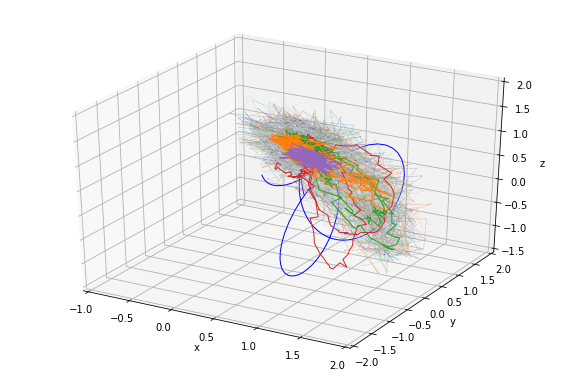

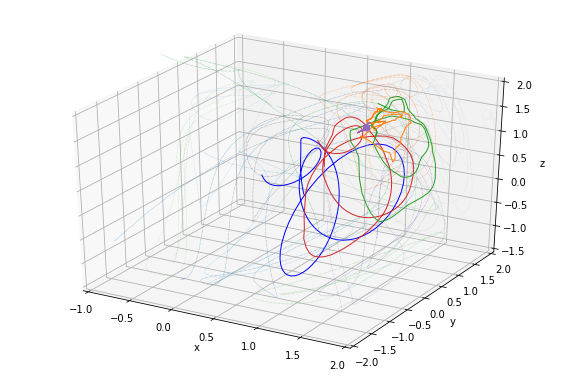

In [52]:
    ###################################################################################
    ########    visualization of lead time dependent prediction - trajectory   ########
    ###################################################################################
    print ('===================    trajectory - truncated  =====================')
    step_lead_display = 6
    
    # forecast rapid sampling
    fig04 = plt.figure(figsize=(8,5.4))
    ax = fig04.gca(projection='3d')

    ax.plot(x[-test_len:], y[-test_len:], z[-test_len:],
            color='blue', label='model output', lw=1.0)
    
    # forecast ensemble member
    for i in range(ens):
        ax.plot(predictand_rapid[i, 0, :, step_lead_display-1] * (x_max - x_min) + x_min,
                predictand_rapid[i, 1, :, step_lead_display-1] * (y_max - y_min) + y_min,
                predictand_rapid[i, 2, :, step_lead_display-1] * (z_max - z_min) + z_min,
                color=colormap[i], linestyle='dotted', label='member {}'.format(i), lw=0.5)
    
    # median
    # step 1    
    ax.plot(predictand_rapid_median[0, :, 0] * (x_max - x_min) + x_min,
            predictand_rapid_median[1, :, 0] * (y_max - y_min) + y_min,
            predictand_rapid_median[2, :, 0] * (z_max - z_min) + z_min,
            color='tab:red', label='median step 1', lw=1.0)
    
    # step 6    
    ax.plot(predictand_rapid_median[0, :, 5] * (x_max - x_min) + x_min,
            predictand_rapid_median[1, :, 5] * (y_max - y_min) + y_min,
            predictand_rapid_median[2, :, 5] * (z_max - z_min) + z_min,
            color='tab:green', label='median step 6', lw=1.0)

    # step 16    
    ax.plot(predictand_rapid_median[0, :, 15] * (x_max - x_min) + x_min,
            predictand_rapid_median[1, :, 15] * (y_max - y_min) + y_min,
            predictand_rapid_median[2, :, 15] * (z_max - z_min) + z_min,
            color='tab:orange', label='median step 16', lw=1.0)

    # step 73   
    ax.plot(predictand_rapid_median[0, :, 72] * (x_max - x_min) + x_min,
            predictand_rapid_median[1, :, 72] * (y_max - y_min) + y_min,
            predictand_rapid_median[2, :, 72] * (z_max - z_min) + z_min,
            color='tab:purple', label='median step 73', lw=1.0)    
        
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    
    ax.set_zlim(-1.5, 2.0)
    ax.set_ylim(-2.0, 2.0)
    ax.set_xlim(-1.0, 2.0)
    #ax.set_title("Lorenz-84 model")
    #plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0, prop={'size': 8.0}, ncol=2)
    plt.tight_layout()
    plt.show()
    fig04.savefig(os.path.join(output_path, 'forecast_rapid_trajectory.png'),dpi=150)
    
    # forecast one-time sampling
    fig05 = plt.figure(figsize=(8,5.4))
    ax = fig05.gca(projection='3d')

    ax.plot(x[-test_len:], y[-test_len:], z[-test_len:],
            color='blue', label='model output', lw=1.0)
    
    # forecast ensemble member
    for i in range(ens):
        ax.plot(predictand_onetime[i, 0, :, step_lead_display-1] * (x_max - x_min) + x_min,
                predictand_onetime[i, 1, :, step_lead_display-1] * (y_max - y_min) + y_min,
                predictand_onetime[i, 2, :, step_lead_display-1] * (z_max - z_min) + z_min,
                color=colormap[i], linestyle='dotted', label='member {}'.format(i), lw=0.5)
    
    # median
    # step 1    
    ax.plot(predictand_onetime_median[0, :, 0] * (x_max - x_min) + x_min,
            predictand_onetime_median[1, :, 0] * (y_max - y_min) + y_min,
            predictand_onetime_median[2, :, 0] * (z_max - z_min) + z_min,
            color='tab:red', label='median step 1', lw=1.0)
    
    # step 6    
    ax.plot(predictand_onetime_median[0, :, 5] * (x_max - x_min) + x_min,
            predictand_onetime_median[1, :, 5] * (y_max - y_min) + y_min,
            predictand_onetime_median[2, :, 5] * (z_max - z_min) + z_min,
            color='tab:green', label='median step 6', lw=1.0)

    # step 16    
    ax.plot(predictand_onetime_median[0, :, 15] * (x_max - x_min) + x_min,
            predictand_onetime_median[1, :, 15] * (y_max - y_min) + y_min,
            predictand_onetime_median[2, :, 15] * (z_max - z_min) + z_min,
            color='tab:orange', label='median step 16', lw=1.0)

    # step 73   
    ax.plot(predictand_onetime_median[0, :, 72] * (x_max - x_min) + x_min,
            predictand_onetime_median[1, :, 72] * (y_max - y_min) + y_min,
            predictand_onetime_median[2, :, 72] * (z_max - z_min) + z_min,
            color='tab:purple', label='median step 73', lw=1.0)    
        
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    
    ax.set_zlim(-1.5, 2.0)
    ax.set_ylim(-2.0, 2.0)
    ax.set_xlim(-1.0, 2.0)
    
    #ax.set_title("Lorenz-84 model")
    #plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0, prop={'size': 8.0}, ncol=2)
    plt.tight_layout()
    plt.show()
    fig05.savefig(os.path.join(output_path, 'forecast_onetime_trajectory.png'),dpi=150)

In [11]:
    ###################################################################################################
    ###########        Launch Lorenz 84 model with periodic forcing with longer series      ###########
    ###################################################################################################
    num_steps_long = num_steps + step_lead
    # Need one more for the initial values
    xx = np.empty(num_steps_long)
    yy = np.empty(num_steps_long)
    zz = np.empty(num_steps_long)
    tt = 0.0
    
    # save initial values
    xx[0] = x_init
    yy[0] = y_init
    zz[0] = z_init
    
    # Step through "time", calculating the partial derivatives at the current point
    # and using them to estimate the next point
    for i in range(num_steps_long-1):
        dx, dy, dz = lorenz84_ex(xx[i], yy[i], zz[i], tt, a, b ,F, G, epsilon)
        xx[i + 1] = xx[i] + (dx * dt)
        yy[i + 1] = yy[i] + (dy * dt)
        zz[i + 1] = zz[i] + (dz * dt)
        tt += dt

In [12]:
    ##############################################################################################################
    ###########       Compute CRPS with given ensemble predictands and deterministic observation       ###########
    ##############################################################################################################
    # lead time dependent CRPS
    crps_onetime = np.zeros((step_lead,3), dtype=float)
    crps_rapid = np.zeros((step_lead,3), dtype=float)
    for i in range(step_lead):
        _, crps_onetime[i,0] = dlacs.metric.CRPS(xx[-(test_len + step_lead)+i:-step_lead+i],
                                                 predictand_onetime[:,0,:,i]* (x_max - x_min) + x_min)
        _, crps_onetime[i,1] = dlacs.metric.CRPS(yy[-(test_len + step_lead)+i:-step_lead+i],
                                                 predictand_onetime[:,1,:,i]* (y_max - y_min) + y_min)
        _, crps_onetime[i,2] = dlacs.metric.CRPS(zz[-(test_len + step_lead)+i:-step_lead+i],
                                                 predictand_onetime[:,2,:,i]* (z_max - z_min) + z_min)

        _, crps_rapid[i,0] = dlacs.metric.CRPS(xx[-(test_len + step_lead)+i:-step_lead+i],
                                                 predictand_rapid[:,0,:,i]* (x_max - x_min) + x_min)
        _, crps_rapid[i,1] = dlacs.metric.CRPS(yy[-(test_len + step_lead)+i:-step_lead+i],
                                                 predictand_rapid[:,1,:,i]* (y_max - y_min) + y_min)
        _, crps_rapid[i,2] = dlacs.metric.CRPS(zz[-(test_len + step_lead)+i:-step_lead+i],
                                                 predictand_rapid[:,2,:,i]* (z_max - z_min) + z_min)

<Figure size 432x288 with 0 Axes>

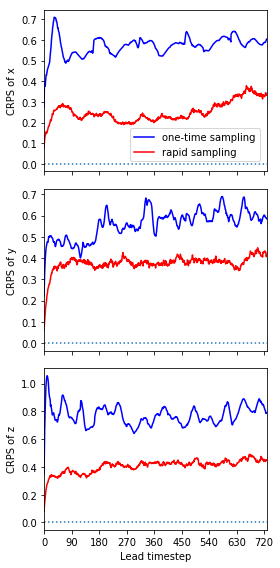

In [26]:
    ##############################################################################################################
    ###########       Compute CRPS with given ensemble predictands and deterministic observation       ###########
    ##############################################################################################################
    # Write CSV file
    with open(os.path.join(output_path, "CRPS_onetime_rapid.csv"), "wt+") as fp:
        writer = csv.writer(fp, delimiter=",")
        writer.writerow(["x", "y", "z" , "one time sampling"])  # write header
        writer.writerow(np.arange(step_lead))  # write header
        writer.writerows(crps_onetime.T)
        writer.writerow(["x", "y", "z" , "rapid sampling"])
        writer.writerow(np.arange(step_lead))  # write header
        writer.writerows(crps_rapid.T)
        
    index = np.arange(0, step_lead)
    
    fig06 = plt.figure()
    fig06, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig06.set_size_inches(4, 8, forward=True)
    
    # forecast
    ax1.plot(np.arange(step_lead), crps_onetime[:,0], 'b', label='one-time sampling')
    ax1.plot(np.arange(step_lead), crps_rapid[:,0], 'r', label='rapid sampling')
    
    ax2.plot(np.arange(step_lead), crps_onetime[:,1], 'b', label='one-time sampling')
    ax2.plot(np.arange(step_lead), crps_rapid[:,1], 'r', label='rapid sampling')
    
    ax3.plot(np.arange(step_lead), crps_onetime[:,2], 'b', label='one-time sampling')
    ax3.plot(np.arange(step_lead), crps_rapid[:,2], 'r', label='rapid sampling')
    
    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')
    
    ax1.set_xlim(0, step_lead)
    ax2.set_xlim(0, step_lead)
    ax3.set_xlim(0, step_lead)
    
    ax1.set_xticks(np.arange(0,step_lead,90))
    ax2.set_xticks(np.arange(0,step_lead,90))
    ax3.set_xticks(np.arange(0,step_lead,90))
    
    #ax1.set_ylim(0, 0.5)
    #ax2.set_ylim(0, 0.5)
    #ax3.set_ylim(0, 0.5)
    
    ax1.set_ylabel("CRPS of x")
    ax2.set_ylabel("CRPS of y")
    ax3.set_ylabel("CRPS of z")
    
    plt.xlabel("Lead timestep")
    
    ax1.legend(frameon=True, bbox_to_anchor=(0.99,0.03), prop={'size': 10.0}, loc=4)
    #ax2.legend(frameon=True, bbox_to_anchor=(0.98,0.05), prop={'size': 7.5}, loc=4)
    #ax3.legend(frameon=True, bbox_to_anchor=(0.98,0.05), prop={'size': 7.5}, loc=4)
    
    plt.tight_layout()

    plt.show()
    fig06.savefig(os.path.join(output_path,'crps_onetime_rapid_long.png'),dpi=100)

<Figure size 432x288 with 0 Axes>

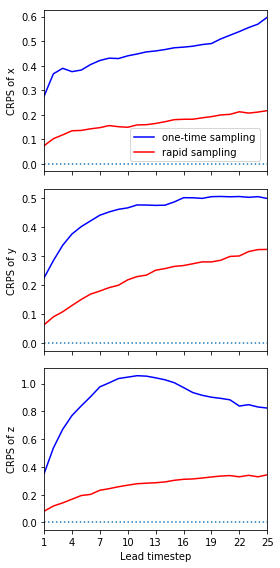

In [16]:
    fig07 = plt.figure()
    fig07, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig07.set_size_inches(4, 8, forward=True)
    
    display_upto = 25
    
    # forecast
    ax1.plot(np.arange(1, display_upto+1), crps_onetime[:display_upto,0], 'b', label='one-time sampling')
    ax1.plot(np.arange(1, display_upto+1), crps_rapid[:display_upto,0], 'r', label='rapid sampling')
    
    ax2.plot(np.arange(1, display_upto+1), crps_onetime[:display_upto,1], 'b', label='one-time sampling')
    ax2.plot(np.arange(1, display_upto+1), crps_rapid[:display_upto,1], 'r', label='rapid sampling')
    
    ax3.plot(np.arange(1, display_upto+1), crps_onetime[:display_upto,2], 'b', label='one-time sampling')
    ax3.plot(np.arange(1, display_upto+1), crps_rapid[:display_upto,2], 'r', label='rapid sampling')
    
    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')
    
    ax1.set_xlim(1, display_upto)
    ax2.set_xlim(1, display_upto)
    ax3.set_xlim(1, display_upto)
    
    ax1.set_xticks(np.arange(1,display_upto+1,3))
    ax2.set_xticks(np.arange(1,display_upto+1,3))
    ax3.set_xticks(np.arange(1,display_upto+1,3))
    
    #ax1.set_ylim(0, 0.5)
    #ax2.set_ylim(0, 0.5)
    #ax3.set_ylim(0, 0.5)
    
    ax1.set_ylabel("CRPS of x")
    ax2.set_ylabel("CRPS of y")
    ax3.set_ylabel("CRPS of z")
    
    plt.xlabel("Lead timestep")
    
    ax1.legend(frameon=True, bbox_to_anchor=(0.99,0.03), prop={'size': 10.0}, loc=4)
    #ax2.legend(frameon=True, bbox_to_anchor=(0.98,0.05), prop={'size': 7.5}, loc=4)
    #ax3.legend(frameon=True, bbox_to_anchor=(0.98,0.05), prop={'size': 7.5}, loc=4)
    
    plt.tight_layout()

    plt.show()
    fig07.savefig(os.path.join(output_path,'crps_onetime_rapid.png'),dpi=100)

In [24]:
    ##############################################################################################################
    ###########       Compute RMSE with given ensemble predictands and deterministic observation       ###########
    ##############################################################################################################
    # RMSE
    def RMSE(obs, pred):
        """
        Root Mean Square Error.
        """
        rmse = np.sqrt(np.mean((obs - pred)**2))
        
        return rmse
    
    # lead time dependent RMSE of Bayesian LSTM forecast
    rmse_onetime = np.zeros((ens, step_lead, 3), dtype=float)
    rmse_rapid = np.zeros((ens, step_lead, 3), dtype=float)
    for i in range(step_lead):
        for n in range(ens):
            rmse_x_onetime = RMSE(xx[-(test_len + step_lead)+i:-step_lead+i], predictand_onetime[n,0,:,i]* (x_max - x_min) + x_min)
            rmse_y_onetime = RMSE(yy[-(test_len + step_lead)+i:-step_lead+i], predictand_onetime[n,1,:,i]* (y_max - y_min) + y_min)
            rmse_z_onetime = RMSE(zz[-(test_len + step_lead)+i:-step_lead+i], predictand_onetime[n,2,:,i]* (z_max - z_min) + z_min)
            
            rmse_x_rapid = RMSE(xx[-(test_len + step_lead)+i:-step_lead+i], predictand_rapid[n,0,:,i]* (x_max - x_min) + x_min)
            rmse_y_rapid = RMSE(yy[-(test_len + step_lead)+i:-step_lead+i], predictand_rapid[n,1,:,i]* (y_max - y_min) + y_min)
            rmse_z_rapid = RMSE(zz[-(test_len + step_lead)+i:-step_lead+i], predictand_rapid[n,2,:,i]* (z_max - z_min) + z_min)
            
            rmse_onetime[n,i,0] = rmse_x_onetime
            rmse_onetime[n,i,1] = rmse_y_onetime
            rmse_onetime[n,i,2] = rmse_z_onetime
            
            rmse_rapid[n,i,0] = rmse_x_rapid
            rmse_rapid[n,i,1] = rmse_y_rapid
            rmse_rapid[n,i,2] = rmse_z_rapid
            
    rmse_onetime_mean = np.mean(rmse_onetime, 0)
    rmse_rapid_mean = np.mean(rmse_rapid, 0)
    
    # for ensemble median at different lead time steps
    target_lead_step = [0, 5, 15, 72]
    rmse_onetime_median = np.zeros((len(target_lead_step), 3), dtype=float)
    rmse_rapid_median = np.zeros((len(target_lead_step), 3), dtype=float)
    
    iterator = 0
    for i in target_lead_step:
        rmse_onetime_median[iterator, 0] = RMSE(xx[-(test_len + step_lead)+i:-step_lead+i],
                                           predictand_onetime_median[0, :, i] * (x_max - x_min) + x_min)
        rmse_onetime_median[iterator, 1] = RMSE(yy[-(test_len + step_lead)+i:-step_lead+i],
                                           predictand_onetime_median[1, :, i] * (y_max - y_min) + y_min)
        rmse_onetime_median[iterator, 2] = RMSE(zz[-(test_len + step_lead)+i:-step_lead+i],
                                           predictand_onetime_median[2, :, i] * (z_max - z_min) + z_min)
        
        rmse_rapid_median[iterator, 0] = RMSE(xx[-(test_len + step_lead)+i:-step_lead+i],
                                      predictand_rapid_median[0, :, i] * (x_max - x_min) + x_min)
        rmse_rapid_median[iterator, 1] = RMSE(yy[-(test_len + step_lead)+i:-step_lead+i],
                                           predictand_rapid_median[1, :, i] * (y_max - y_min) + y_min)
        rmse_rapid_median[iterator, 2] = RMSE(zz[-(test_len + step_lead)+i:-step_lead+i],
                                           predictand_rapid_median[2, :, i] * (z_max - z_min) + z_min)
        iterator +=1

    # Write CSV file
    with open(os.path.join(output_path, "RMSE_onetime_rapid_median.csv"), "wt+") as fp:
        writer = csv.writer(fp, delimiter=",")
        writer.writerow(["x", "y", "z", "onetime"])  # write header
        writer.writerow(target_lead_step)  # write header
        writer.writerows(rmse_onetime_median.T)
        writer.writerow(["x", "y", "z", "rapid"])
        writer.writerow(target_lead_step)  # write header
        writer.writerows(rmse_rapid_median.T)

<Figure size 432x288 with 0 Axes>

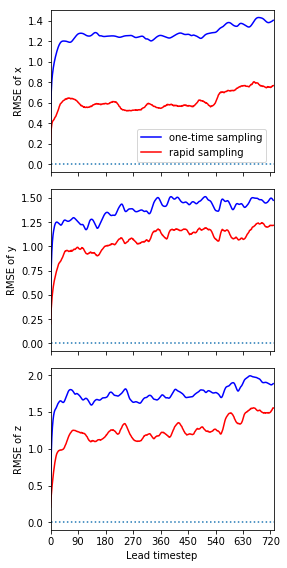

In [25]:
    ##############################################################################################################
    ###########       Compute RMSE with given ensemble predictands and deterministic observation       ###########
    ##############################################################################################################
    # Write CSV file
    with open(os.path.join(output_path, "RMSE_onetime_rapid.csv"), "wt+") as fp:
        writer = csv.writer(fp, delimiter=",")
        writer.writerow(["x", "y", "z", "onetime"])  # write header
        writer.writerow(np.arange(step_lead))  # write header
        writer.writerows(rmse_onetime_mean.T)
        writer.writerow(["x", "y", "z", "rapid"])
        writer.writerow(np.arange(step_lead))  # write header
        writer.writerows(rmse_rapid_mean.T)
        
    index = np.arange(0, step_lead)
    
    fig08 = plt.figure()
    fig08, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig08.set_size_inches(4, 8, forward=True)
    
    # rmse of forecast
    ax1.plot(np.arange(step_lead), rmse_onetime_mean[:,0], 'b', label='one-time sampling')
    ax1.plot(np.arange(step_lead), rmse_rapid_mean[:,0], 'r', label='rapid sampling')
    
    ax2.plot(np.arange(step_lead), rmse_onetime_mean[:,1], 'b', label='one-time sampling')
    ax2.plot(np.arange(step_lead), rmse_rapid_mean[:,1], 'r', label='rapid sampling')
    
    ax3.plot(np.arange(step_lead), rmse_onetime_mean[:,2], 'b', label='one-time sampling')
    ax3.plot(np.arange(step_lead), rmse_rapid_mean[:,2], 'r', label='rapid sampling')
    
    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')
    
    ax1.set_xlim(0, step_lead)
    ax2.set_xlim(0, step_lead)
    ax3.set_xlim(0, step_lead)
    
    ax1.set_xticks(np.arange(0,step_lead,90))
    ax2.set_xticks(np.arange(0,step_lead,90))
    ax3.set_xticks(np.arange(0,step_lead,90))
    
    #ax1.set_ylim(0, 0.5)
    #ax2.set_ylim(0, 0.5)
    #ax3.set_ylim(0, 0.5)
    
    ax1.set_ylabel("RMSE of x")
    ax2.set_ylabel("RMSE of y")
    ax3.set_ylabel("RMSE of z")
    
    plt.xlabel("Lead timestep")
    
    ax1.legend(frameon=True, bbox_to_anchor=(0.99,0.03), prop={'size': 10.0}, loc=4)
    #ax2.legend(frameon=True, bbox_to_anchor=(0.98,0.05), prop={'size': 7.5}, loc=4)
    #ax3.legend(frameon=True, bbox_to_anchor=(0.98,0.05), prop={'size': 7.5}, loc=4)
    
    plt.tight_layout()

    plt.show()
    fig08.savefig(os.path.join(output_path,'rmse_onetime_rapid_long.png'),dpi=100)

<Figure size 432x288 with 0 Axes>

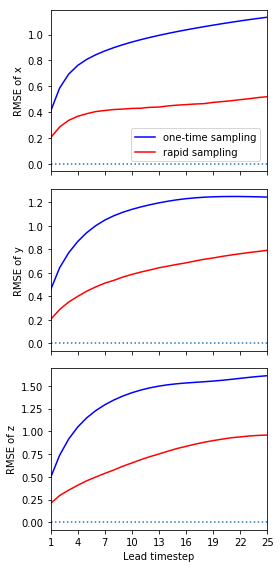

In [18]:
    # zoom in
    fig09 = plt.figure()
    fig09, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig09.set_size_inches(4, 8, forward=True)
    
    display_upto = 25
    
    # rmse of forecast
    ax1.plot(np.arange(1, display_upto+1), rmse_onetime_mean[:display_upto,0], 'b', label='one-time sampling')
    ax1.plot(np.arange(1, display_upto+1), rmse_rapid_mean[:display_upto,0], 'r', label='rapid sampling')
    
    ax2.plot(np.arange(1, display_upto+1), rmse_onetime_mean[:display_upto,1], 'b', label='one-time sampling')
    ax2.plot(np.arange(1, display_upto+1), rmse_rapid_mean[:display_upto,1], 'r', label='rapid sampling')
    
    ax3.plot(np.arange(1, display_upto+1), rmse_onetime_mean[:display_upto,2], 'b', label='one-time sampling')
    ax3.plot(np.arange(1, display_upto+1), rmse_rapid_mean[:display_upto,2], 'r', label='rapid sampling')    
    
    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')
    
    ax1.set_xlim(1, display_upto)
    ax2.set_xlim(1, display_upto)
    ax3.set_xlim(1, display_upto)
    
    ax1.set_xticks(np.arange(1,display_upto+1,3))
    ax2.set_xticks(np.arange(1,display_upto+1,3))
    ax3.set_xticks(np.arange(1,display_upto+1,3))
    
    #ax1.set_ylim(0, 0.5)
    #ax2.set_ylim(0, 0.5)
    #ax3.set_ylim(0, 0.5)
    
    ax1.set_ylabel("RMSE of x")
    ax2.set_ylabel("RMSE of y")
    ax3.set_ylabel("RMSE of z")
    
    plt.xlabel("Lead timestep")
    
    ax1.legend(frameon=True, bbox_to_anchor=(0.99,0.03), prop={'size': 10.0}, loc=4)
    #ax2.legend(frameon=True, bbox_to_anchor=(0.98,0.05), prop={'size': 7.5}, loc=4)
    #ax3.legend(frameon=True, bbox_to_anchor=(0.98,0.05), prop={'size': 7.5}, loc=4)
    
    plt.tight_layout()

    plt.show()
    fig09.savefig(os.path.join(output_path,'rmse_onetime_rapid.png'),dpi=100)

In [25]:
    ##############################################################################################################
    ###########       Compute Euclidean distance with given ensemble predictands and observation       ###########
    ##############################################################################################################
    # Euclidean distance
    def Euclidean(obs, pred):
        """
        Measure the Euclidean distance.
        ----------------------
        param obs: observation time series with the shape [dim, series]
        param pred: reference time series with the shape [dim, series]        
        """
        euclidean = np.mean(np.sqrt(np.sum((obs-pred)**2,0)))
        
        return euclidean
    
    # lead time dependent Euclidean distance of Bayesian forecast
    euclidean_onetime_ens = np.zeros((ens, step_lead), dtype=float)
    euclidean_rapid_ens = np.zeros((ens, step_lead), dtype=float)
    
    obs = np.zeros((3, num_steps_long), dtype=float)
    obs[0,:] = xx[:]
    obs[1,:] = yy[:]
    obs[2,:] = zz[:]
    
    predictand_onetime_denorm = np.zeros(predictand_onetime.shape, dtype=float)
    predictand_onetime_denorm[:,0,:,:] = predictand_onetime[:,0,:,:] * (x_max - x_min) + x_min
    predictand_onetime_denorm[:,1,:,:] = predictand_onetime[:,1,:,:] * (y_max - y_min) + y_min
    predictand_onetime_denorm[:,2,:,:] = predictand_onetime[:,2,:,:] * (z_max - z_min) + z_min
    
    predictand_rapid_denorm = np.zeros(predictand_rapid.shape, dtype=float)
    predictand_rapid_denorm[:,0,:,:] = predictand_rapid[:,0,:,:] * (x_max - x_min) + x_min
    predictand_rapid_denorm[:,1,:,:] = predictand_rapid[:,1,:,:] * (y_max - y_min) + y_min
    predictand_rapid_denorm[:,2,:,:] = predictand_rapid[:,2,:,:] * (z_max - z_min) + z_min
    
    predictand_onetime_denorm_median = np.median(predictand_onetime_denorm, 0)
    predictand_rapid_denorm_median = np.median(predictand_rapid_denorm, 0)
    
    for i in range(step_lead):
        for n in range(ens):
            euclidean_onetime_n = Euclidean(obs[:,-(test_len + step_lead)+i:-step_lead+i], predictand_onetime_denorm[n,:,:,i])
            euclidean_rapid_n = Euclidean(obs[:,-(test_len + step_lead)+i:-step_lead+i], predictand_rapid_denorm[n,:,:,i])
            
            euclidean_onetime_ens[n,i] = euclidean_onetime_n
            euclidean_rapid_ens[n,i] = euclidean_rapid_n
            
    euclidean_onetime = np.mean(euclidean_onetime_ens, 0)
    euclidean_rapid = np.mean(euclidean_rapid_ens, 0)
    
    # for ensemble median at different lead time steps
    target_lead_step = [0, 5, 15, 72]
    euclidean_onetime_median = np.zeros(len(target_lead_step), dtype=float)
    euclidean_rapid_median = np.zeros(len(target_lead_step), dtype=float)
    
    iterator = 0
    for i in target_lead_step:
        euclidean_onetime_median[iterator] = Euclidean(obs[:,-(test_len + step_lead)+i:-step_lead+i], predictand_onetime_denorm_median[:,:,i])
        
        euclidean_rapid_median[iterator] = Euclidean(obs[:,-(test_len + step_lead)+i:-step_lead+i], predictand_rapid_denorm_median[:,:,i])
        
        iterator +=1

    # Write CSV file
    with open(os.path.join(output_path, "EuclideanD_onetime_rapid_median.csv"), "wt+") as fp:
        writer = csv.writer(fp, delimiter=",")
        writer.writerow(["Euclidean", "onetime"])  # write header
        writer.writerow(target_lead_step)  # write header
        writer.writerow(euclidean_onetime_median)
        writer.writerow(["Euclidean", "rapid"])  # write header
        writer.writerow(target_lead_step)  # write header
        writer.writerow(euclidean_rapid_median)

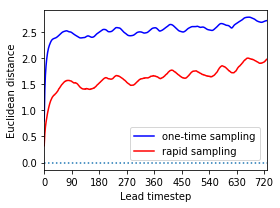

In [29]:
    ##############################################################################################################
    ###########       Compute Euclidean distance with given ensemble predictands and observation       ###########
    ##############################################################################################################
    # Write CSV file
    with open(os.path.join(output_path, "EuclideanD_onetime_rapid.csv"), "wt+") as fp:
        writer = csv.writer(fp, delimiter=",")
        writer.writerow(["Euclidean", "onetime"])  # write header
        writer.writerow(np.arange(step_lead))  # write header
        writer.writerow(euclidean_onetime)
        writer.writerow(["Euclidean", "rapid"])  # write header
        writer.writerow(np.arange(step_lead))  # write header
        writer.writerow(euclidean_rapid)
        
    index = np.arange(0, step_lead)
    
    fig10 = plt.figure()
    fig10.set_size_inches(4, 3, forward=True)
    plt.plot(np.arange(step_lead), euclidean_onetime[:], 'b', label='one-time sampling')
    plt.plot(np.arange(step_lead), euclidean_rapid[:], 'r', label='rapid sampling')
    plt.axhline(y=0, ls = ':')
    plt.xlim(0, step_lead)
    plt.xticks(np.arange(0,step_lead,90))
    
    #plt.ylim(0, 0.5)    
    plt.ylabel("Euclidean distance")
    plt.xlabel("Lead timestep")
    
    plt.legend(frameon=True, prop={'size': 10.0}, bbox_to_anchor=(0.99,0.03), loc=4)
    plt.tight_layout()
    plt.show()
    fig10.savefig(os.path.join(output_path,'euclidean_onetime_rapid_long.png'),dpi=100)

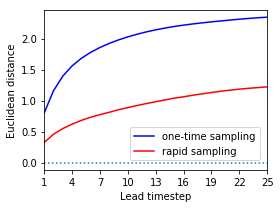

In [20]:
    # zoom in
    display_upto = 25
    
    fig11 = plt.figure()
    fig11.set_size_inches(4, 3, forward=True)
    
    plt.plot(np.arange(1, display_upto+1), euclidean_onetime[:display_upto], 'b', label='one-time sampling')
    plt.plot(np.arange(1, display_upto+1), euclidean_rapid[:display_upto], 'r', label='rapid sampling')
    plt.axhline(y=0, ls = ':')
    plt.xlim(1, display_upto)
    plt.xticks(np.arange(1,display_upto+1,3))
    
    #plt.ylim(0, 0.5)    
    plt.ylabel("Euclidean distance")
    plt.xlabel("Lead timestep")
    
    plt.legend(frameon=True, prop={'size': 10.0}, bbox_to_anchor=(0.99,0.03), loc=4)
    plt.tight_layout()

    plt.show()
    fig11.savefig(os.path.join(output_path,'euclidean_onetime_rapid.png'),dpi=100)